In [1]:
import numpy as np
from gurobipy import *
import gurobipy as gp
from gurobipy import GRB

In [2]:
env = gp.Env(empty=True)
env.setParam("OutputFlag", 0)
env.start()

<gurobipy.Env, Parameter changes: OutputFlag=0>

In [3]:
def second_stage_solution_underloaded(c_reduced, a, x, b_true):
    n = len(c_reduced)  # Number of variables

    b_underload = b_true - sum(a[i] * x[i] for i in range(n))

    # Create a new model
    model = gp.Model("optimization_problem", env=env)

    # Create decision variables
    y_plus = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="y_plus")

    # Set objective function
    model.setObjective(
        sum(c_reduced[i] * y_plus[i] for i in range(n)), sense=GRB.MAXIMIZE
    )

    # Add constraints
    for k in range(n):
        model.addConstr(y_plus[k] <= 1 - x[k])

    model.addConstr(sum(a[i] * y_plus[i] for i in range(n)) <= b_underload)

    # Optimize the model
    model.optimize()

    # Retrieve the solution
    if model.status == GRB.OPTIMAL:
        optimal_solution = [y_plus[i].x for i in range(n)]
        optimal_objective = model.objVal
        return optimal_solution, optimal_objective
    else:
        # print("No solution found")
        return [0] * n, 0

In [4]:
def second_stage_solution_overloaded(d, x, a, b_true):
    n = len(x)  # Number of variables

    b_overload = sum(a[i] * x[i] for i in range(n)) - b_true

    # Create a new model
    model = gp.Model("optimization_problem", env=env)

    # Create decision variables
    y_minus = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="y_minus")

    # Set objective function
    model.setObjective(sum(d * y_minus[i] for i in range(n)), sense=GRB.MINIMIZE)

    # Add constraints
    for k in range(n):
        model.addConstr(y_minus[k] <= x[k])

    model.addConstr(sum(a[i] * y_minus[i] for i in range(n)) >= b_overload)

    # Optimize the model
    model.optimize()

    # Retrieve the solution
    if model.status == GRB.OPTIMAL:
        optimal_solution = [y_minus[i].x for i in range(n)]
        optimal_objective = model.objVal
        return optimal_solution, optimal_objective
    else:
        # print("No solution found")
        return [0] * n, 0

In [5]:
from scipy.stats import norm


def norm_cdf(x, mu, sigma):
    return norm.cdf(x, loc=mu, scale=sigma)

In [6]:
def first_stage_solution(c, a, b_stochastic):
    # print("xi: ", xi)

    n = len(c)  # Number of variables

    # Create a new model
    model = gp.Model("first_stage_problem", env=env)

    # Create decision variables
    x = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="x")

    # Set objective function
    model.setObjective(sum(c[i] * x[i] for i in range(n)), sense=GRB.MAXIMIZE)

    # Add constraints
    model.addConstr(sum(a[i] * x[i] for i in range(n)) <= b_stochastic)

    # Optimize the model
    model.optimize()

    # Retrieve the solution
    if model.status == GRB.OPTIMAL:
        optimal_solution = [x[i].x for i in range(n)]
        optimal_objective = model.objVal
        return optimal_solution, optimal_objective
    else:
        return None

In [7]:
n = 10  # number of items in the knapsack
a = [3, 10, 5, 7, 4, 1, 6, 2, 8, 1]  # weights
c = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # values

b = 15  # capacity of the knapsack
nu = 0  # mean of the normal distribution
sigma = 10  # standard deviation of the normal distribution
epsilon = 7  # threshold for the normal distribution
d = 12  # cost of overloading the knapsack
c_redused = [c[i] / 2 for i in range(n)]  # cost of underloading the knapsack

N = 10000  # number of scenarios


def sample_average_approximation(a, c, b, nu, sigma, epsilon, d, c_redused, N):
    first_st_sol = []
    second_st_sol_un = []
    second_st_sol_ov = []
    xis = []

    distribution = norm(loc=nu, scale=sigma)

    true_xi = distribution.rvs()
    while abs(true_xi) > epsilon:
        true_xi = distribution.rvs()

    true_b = b + true_xi

    for i in range(N):
        xi = distribution.rvs()
        while abs(xi) > epsilon:
            xi = distribution.rvs()
        b_stochastic = b + xi

        x, obj = first_stage_solution(c, a, b_stochastic)
        y_plus, obj_plus = second_stage_solution_underloaded(c_redused, a, x, true_b)
        y_minus, obj_minus = second_stage_solution_overloaded(d, x, a, true_b)

        first_st_sol.append(obj)
        second_st_sol_un.append(obj_plus)
        second_st_sol_ov.append(obj_minus)
        xis.append(xi)
    return first_st_sol, second_st_sol_un, second_st_sol_ov, xis, true_xi

In [8]:
(
    first_st_sol,
    second_st_sol_un,
    second_st_sol_ov,
    xis,
    true_xi,
) = sample_average_approximation(a, c, b, nu, sigma, epsilon, d, c_redused, N)

In [9]:
true_xi

-6.893025972947504

In [10]:
final_obj = []
for i in range(N):
    final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])

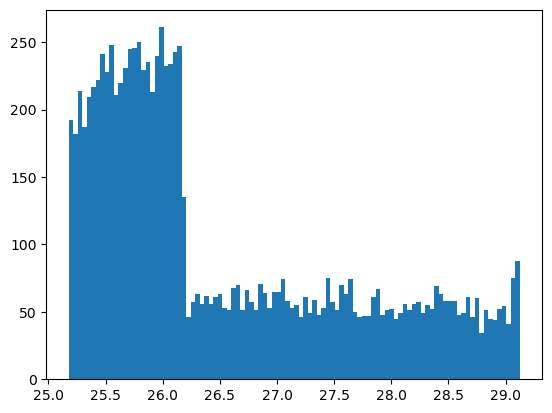

In [11]:
import matplotlib.pyplot as plt

plt.hist(final_obj, bins=100)
plt.show()

In [12]:
print("Mean: ", np.mean(final_obj))
print("Standard deviation: ", np.std(final_obj))
print("Minimum: ", min(final_obj))
print("Maximum: ", max(final_obj))

Mean:  26.512976136240795
Standard deviation:  1.1235112795438251
Minimum:  25.178619948059534
Maximum:  29.124681532368687


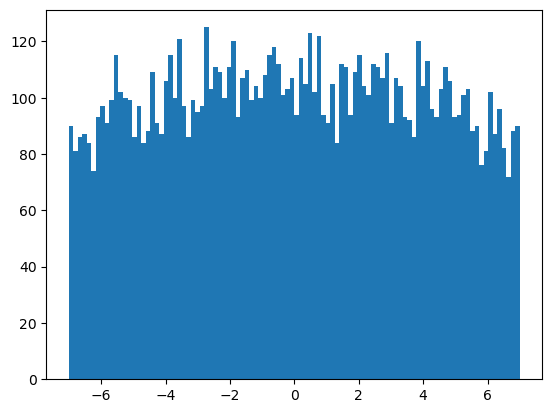

In [13]:
plt.hist(xis, bins=100)
plt.show()

In [14]:
max_arg = np.argmax(final_obj)
min_arg = np.argmin(final_obj)

In [15]:
xis[max_arg], xis[min_arg]

(-6.893234257277605, 6.997360776223635)

In [16]:
max_xi = xis[max_arg]

In [17]:
x, obj = first_stage_solution(c, a, b + true_xi)
obj

29.124803031561246

In [18]:
def sample_average_approximation_robust(
    a, c, b, nu, sigma, epsilon, d, c_redused, N, polarity
):
    first_st_sol = []
    second_st_sol_un = []
    second_st_sol_ov = []
    xis = []

    distribution = norm(loc=nu, scale=sigma)

    true_xi = distribution.rvs()
    while abs(true_xi) > epsilon:
        true_xi = distribution.rvs()

    true_b = b + true_xi

    for i in range(N):
        xi = distribution.rvs()
        while abs(xi) > epsilon:
            xi = distribution.rvs()
        b_stochastic = b + xi

        if polarity == "underload":
            b_stochastic -= epsilon
        elif polarity == "overload":
            b_stochastic += epsilon
        else:
            raise NotImplemented

        x, obj = first_stage_solution(c, a, b_stochastic)
        y_plus, obj_plus = second_stage_solution_underloaded(c_redused, a, x, true_b)
        y_minus, obj_minus = second_stage_solution_overloaded(d, x, a, true_b)

        first_st_sol.append(obj)
        second_st_sol_un.append(obj_plus)
        second_st_sol_ov.append(obj_minus)
        xis.append(xi)
    return first_st_sol, second_st_sol_un, second_st_sol_ov, xis, true_xi

In [19]:
d = 10
c_redused = [-c[i] for i in range(n)]  # cost of underloading the knapsack

In [20]:
(
    first_st_sol,
    second_st_sol_un,
    second_st_sol_ov,
    xis,
    true_xi,
) = sample_average_approximation_robust(
    a, c, b, nu, sigma, epsilon, d, c_redused, N, "underload"
)
true_xi

2.199575745520501

In [21]:
final_obj = []
for i in range(N):
    final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])

In [22]:
print("Mean: ", np.mean(final_obj))
print("Standard deviation: ", np.std(final_obj))
print("Minimum: ", min(final_obj))
print("Maximum: ", max(final_obj))

Mean:  27.966100773935825
Standard deviation:  6.322484540153514
Minimum:  10.018419711943142
Maximum:  37.12440096521835


In [23]:
x, obj = first_stage_solution(c, a, b + true_xi)
obj

39.59952271371056

In [24]:
(
    first_st_sol,
    second_st_sol_un,
    second_st_sol_ov,
    xis,
    true_xi,
) = sample_average_approximation_robust(
    a, c, b, nu, sigma, epsilon, d, c_redused, N, "overload"
)
true_xi

-5.444754071839841

In [25]:
final_obj = []
for i in range(N):
    final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])

In [26]:
print("Mean: ", np.mean(final_obj))
print("Standard deviation: ", np.std(final_obj))
print("Minimum: ", min(final_obj))
print("Maximum: ", max(final_obj))

Mean:  25.765851821223173
Standard deviation:  2.889193905426467
Minimum:  19.39671535010544
Maximum:  28.466874464926672


In [27]:
x, obj = first_stage_solution(c, a, b + true_xi)
obj

30.814453582853517

In [76]:
d = 12
c_redused = [c[i] / 2 for i in range(n)]  # cost of underloading the knapsack

In [77]:
def true_fixed(
        a, c, b, nu, sigma, epsilon, d, c_redused, N, polarity, true
):
    first_st_sol = []
    second_st_sol_un = []
    second_st_sol_ov = []
    xis = []

    distribution = norm(loc=nu, scale=sigma)

    # true_xi = distribution.rvs()
    # while abs(true_xi) > epsilon:
    #     true_xi = distribution.rvs()

    # true_b = b + true_xi

    true_b = b + true

    for i in range(N):
        xi = distribution.rvs()
        while abs(xi) > epsilon:
            xi = distribution.rvs()
        b_stochastic = b + xi

        if polarity == "underload":
            b_stochastic -= epsilon
        elif polarity == "overload":
            b_stochastic += epsilon
        else:
            raise NotImplemented

        x, obj = first_stage_solution(c, a, b_stochastic)
        y_plus, obj_plus = second_stage_solution_underloaded(c_redused, a, x, true_b)
        y_minus, obj_minus = second_stage_solution_overloaded(d, x, a, true_b)

        first_st_sol.append(obj)
        second_st_sol_un.append(obj_plus)
        second_st_sol_ov.append(obj_minus)
        xis.append(xi)
    return first_st_sol, second_st_sol_un, second_st_sol_ov, xis, true_xi

In [78]:
true_xis = [-7, -5, -3, -1, 1, 3, 5, 7]

In [79]:
means_under = []
means_over = []

for elem in true_xis:
    (
        first_st_sol,
        second_st_sol_un,
        second_st_sol_ov,
        xis,
        true_xi,
    ) = true_fixed(
        a, c, b, nu, sigma, epsilon, d, c_redused, 1000, "underload", elem
    )
    final_obj = []
    for i in range(1000):
        final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])
    means_under.append(np.mean(final_obj))

    (
        first_st_sol,
        second_st_sol_un,
        second_st_sol_ov,
        xis,
        true_xi,
    ) = true_fixed(
        a, c, b, nu, sigma, epsilon, d, c_redused, 1000, "overload", elem
    )

    final_obj = []
    for i in range(1000):
        final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])
    means_over.append(np.mean(final_obj))

In [82]:
true_bs = [b + elem for elem in true_xis]

In [83]:
true_obj = []
for elem in true_bs:
    x, obj = first_stage_solution(c, a, elem)
    true_obj.append(obj)

In [90]:
true_obj

[29.0, 31.333333333333332, 33.666666666666664, 36.0, 38.25, 40.5, 42.75, 45.0]

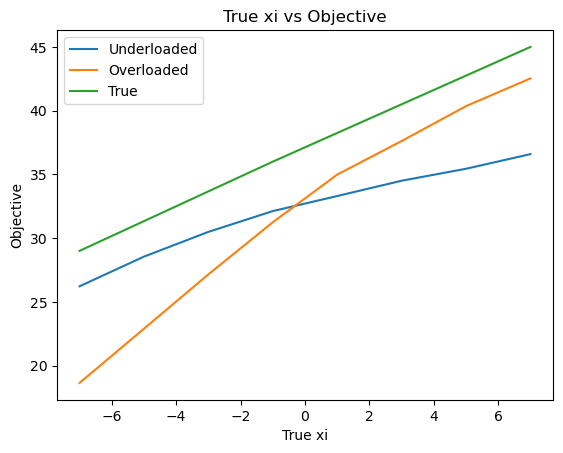

In [84]:
# plot under, over, true

plt.plot(true_xis, means_under, label="Underloaded")
plt.plot(true_xis, means_over, label="Overloaded")
plt.plot(true_xis, true_obj, label="True")
plt.legend()
plt.xlabel("True xi")
plt.ylabel("Objective")
plt.title("True xi vs Objective")
plt.show()

In [85]:
d = 50
c_redused = [c[i] / 2 for i in range(n)]  # cost of underloading the knapsack

In [86]:
means_under = []
means_over = []

for elem in true_xis:
    (
        first_st_sol,
        second_st_sol_un,
        second_st_sol_ov,
        xis,
        true_xi,
    ) = true_fixed(
        a, c, b, nu, sigma, epsilon, d, c_redused, 1000, "underload", elem
    )
    final_obj = []
    for i in range(1000):
        final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])
    means_under.append(np.mean(final_obj))

    (
        first_st_sol,
        second_st_sol_un,
        second_st_sol_ov,
        xis,
        true_xi,
    ) = true_fixed(
        a, c, b, nu, sigma, epsilon, d, c_redused, 1000, "overload", elem
    )

    final_obj = []
    for i in range(1000):
        final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])
    means_over.append(np.mean(final_obj))

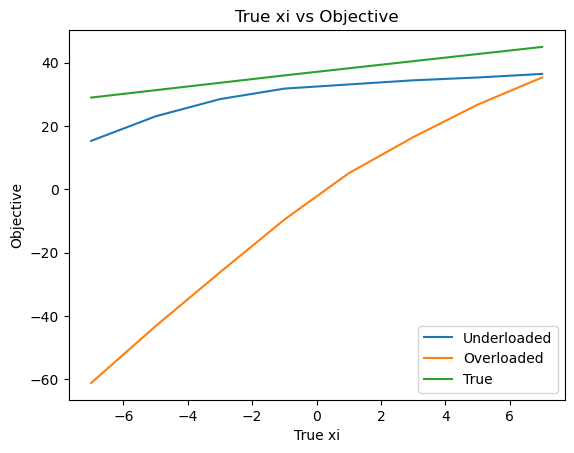

In [87]:
# plot under, over, true

plt.plot(true_xis, means_under, label="Underloaded")
plt.plot(true_xis, means_over, label="Overloaded")
plt.plot(true_xis, true_obj, label="True")
plt.legend()
plt.xlabel("True xi")
plt.ylabel("Objective")
plt.title("True xi vs Objective")
plt.show()

In [88]:
d = 10
c_redused = [-c[i] * 2 for i in range(n)]  # cost of underloading the knapsack
means_under = []
means_over = []

for elem in true_xis:
    (
        first_st_sol,
        second_st_sol_un,
        second_st_sol_ov,
        xis,
        true_xi,
    ) = true_fixed(
        a, c, b, nu, sigma, epsilon, d, c_redused, 1000, "underload", elem
    )
    final_obj = []
    for i in range(1000):
        final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])
    means_under.append(np.mean(final_obj))

    (
        first_st_sol,
        second_st_sol_un,
        second_st_sol_ov,
        xis,
        true_xi,
    ) = true_fixed(
        a, c, b, nu, sigma, epsilon, d, c_redused, 1000, "overload", elem
    )

    final_obj = []
    for i in range(1000):
        final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])
    means_over.append(np.mean(final_obj))

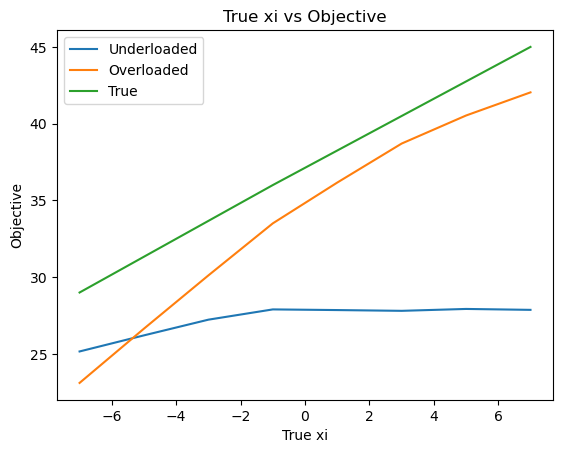

In [89]:
# plot under, over, true

plt.plot(true_xis, means_under, label="Underloaded")
plt.plot(true_xis, means_over, label="Overloaded")
plt.plot(true_xis, true_obj, label="True")
plt.legend()
plt.xlabel("True xi")
plt.ylabel("Objective")
plt.title("True xi vs Objective")
plt.show()